In [58]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [12]:
mappings = np.load("python_mappings.npy")
print(mappings.shape)






(96, 144)


In [13]:
def reorder3(data):
    # Get number of variables N from input shape
    n_vars = data.shape[1] if len(data.shape) > 1 else 1
    
    # Initialize return array with shape (96*144, N)
    ret = np.empty([96*144, n_vars])
    
    # For each grid point
    for i in range(96):
        for j in range(144):
            # Calculate output index
            out_idx = i*144 + j
            # Copy all variables for this point using the mapping
            if len(data.shape) == 1:
                ret[out_idx] = data[mappings[i][j]]
            else:
                ret[out_idx,:] = data[mappings[i][j],:]
            
    return ret 

In [6]:
import sys
import os
sys.path.append(os.path.join('/Users/jianda/Projects/nncam_training/', 'models'))
from models import ResMLP

In [18]:
crash_model = ResMLP(249, 30, 512, 'relu', 7)
crash_checkpoint = torch.load('/Users/jianda/Projects/experience_replay_models/noreplay_buffer309_v3_seed1117_sample2_noprevQT_std_mix1.0/0_29_checkpoint_best_loss.pth.tar', map_location=torch.device('cpu'))
# Remove 'module.' prefix from state dict keys
crash_checkpoint['state_dict'] = {k.replace('module.', ''): v for k, v in crash_checkpoint['state_dict'].items()}

crash_model.load_state_dict(crash_checkpoint['state_dict'])


/var/folders/77/477dplbj7210xzg98wgtl28w0000gn/T/ipykernel_18440/2715037135.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  crash_checkpoint = torch.load('/Users/jianda/

<All keys matched successfully>

In [19]:
stable_model = ResMLP(249, 30, 512, 'relu', 7)
stable_checkpoint = torch.load('/Users/jianda/Projects/experience_replay_models/replay_buffer309_v3_seed1117_sample2_noprevQT_std_mix1.0/0_29_checkpoint_best_loss.pth.tar', map_location=torch.device('cpu'))
# Remove 'module.' prefix from state dict keys
stable_checkpoint['state_dict'] = {k.replace('module.', ''): v for k, v in stable_checkpoint['state_dict'].items()}

stable_model.load_state_dict(stable_checkpoint['state_dict'])


/var/folders/77/477dplbj7210xzg98wgtl28w0000gn/T/ipykernel_18440/2891335341.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stable_checkpoint = torch.load('/Users/jianda

<All keys matched successfully>

(13824, 309)
torch.Size([13824, 30])
torch.Size([13824, 30])


/var/folders/77/477dplbj7210xzg98wgtl28w0000gn/T/ipykernel_18440/3071742946.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


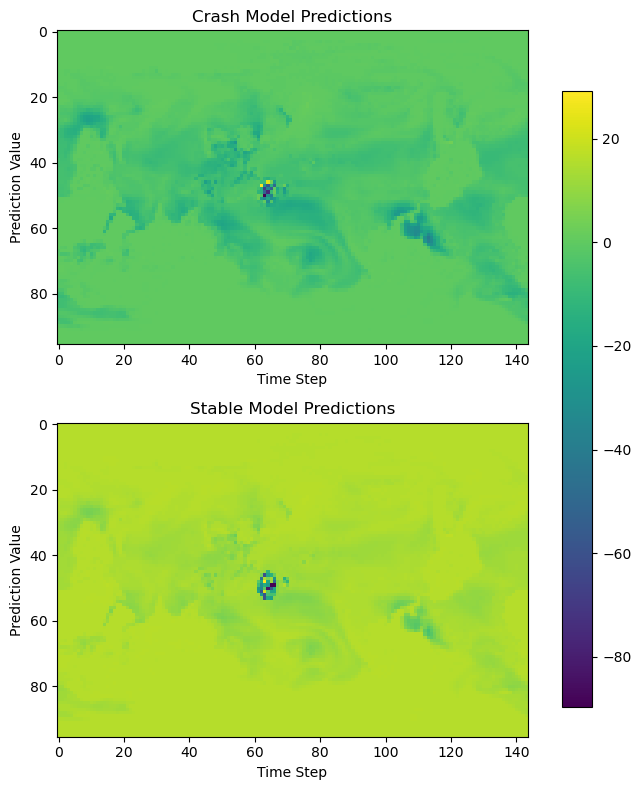

In [39]:
x_input = np.load("/Volumes/data_backup/experience_replay_data/online_data/noreplay_std/coupled_53.npz")['x']
x_input = reorder3(x_input)
print(x_input.shape)

crash_pred = crash_model(torch.from_numpy(x_input[:,60:]).float())
print(crash_pred.shape)
stable_pred = stable_model(torch.from_numpy(x_input[:,60:]).float())
print(stable_pred.shape)
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot crash predictions
im1 = ax1.imshow(crash_pred.detach().numpy()[:,29].reshape(96,144))
ax1.set_title('Crash Model Predictions')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Prediction Value')

# Plot stable predictions 
ax2.imshow(stable_pred.detach().numpy()[:,29].reshape(96,144    ))
ax2.set_title('Stable Model Predictions')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Prediction Value')

# Add colorbar
fig.colorbar(im1, ax=(ax1, ax2))

# Adjust layout to make room for colorbar
plt.tight_layout()
fig.subplots_adjust(right=0.75)
plt.show()


(13824, 309)
torch.Size([13824, 30])
torch.Size([13824, 30])


/var/folders/77/477dplbj7210xzg98wgtl28w0000gn/T/ipykernel_18440/2734190716.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


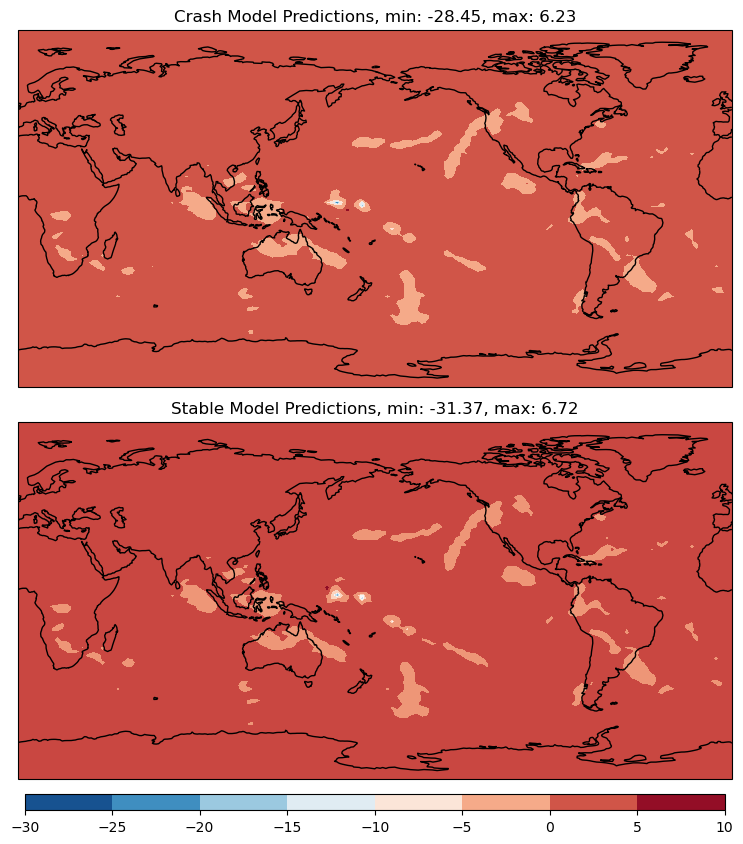

In [78]:
level = 27
x_input = np.load("/Volumes/data_backup/experience_replay_data/online_data/noreplay_std/coupled_53.npz")['x']
x_input = reorder3(x_input)
print(x_input.shape)

crash_pred = crash_model(torch.from_numpy(x_input[:,60:]).float())
print(crash_pred.shape)
stable_pred = stable_model(torch.from_numpy(x_input[:,60:]).float())
print(stable_pred.shape)

# Create figure with two subplots using cartopy projections
fig = plt.figure(figsize=(10, 8))
proj = ccrs.PlateCarree(central_longitude=180)

ax1 = fig.add_subplot(2, 1, 1, projection=proj)
ax2 = fig.add_subplot(2, 1, 2, projection=proj)
# Add map features
for ax in [ax1, ax2]:
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgray')
    # ax.gridlines()

# Create lat/lon arrays for plotting
lats = np.linspace(-90, 90, 96)
lons = np.linspace(0, 360, 144)
lon, lat = np.meshgrid(lons, lats)

# Plot crash predictions
crash_data = crash_pred.detach().numpy()[:,15].reshape(96,144)
im1 = ax1.contourf(lon, lat, crash_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax1.set_title(f'Crash Model Predictions, min: {crash_data.min():.2f}, max: {crash_data.max():.2f}')

# Plot stable predictions
stable_data = stable_pred.detach().numpy()[:,15].reshape(96,144)
im2 = ax2.contourf(lon, lat, stable_data, transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax2.set_title(f'Stable Model Predictions, min: {stable_data.min():.2f}, max: {stable_data.max():.2f}')

# Add colorbar at the bottom
cbar_ax = fig.add_axes([0.15, -0.02, 0.7, 0.02])
fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')

plt.tight_layout()
plt.show()
